# Highland Lakes Storm Inflow Predictive Model

![highlandlakes](images/highlandlakes2008.jpg)

--- 

## Summary

A predictive machine learning model to estimate the lake inflows after major storms in the Austin, Texas area.

The highland lakes are managed by the Lower Colorado River Authority (LCRA) and protect the downstream urban population living in the floodplain. A major multi-decade drought shifted the public focus from flood control to water conservation in the greater Austin area. In 2015, a major storm ended the drought and refilled the lakes.

The highland lake levels are frequently reported by the local news media and monitored by ordinary Austinites and Texans in the surrounding area. It is not uncommon to hear area residents speaking about how the lakes are doing.

The lakes are important to many area residents for multiple reasons:
* Recreational (boating)
* Financial (business water use)
* Lawn-care and other homeowner restrictions (drought conditions limit water use)  


This model intends to predict lake inflows during storm periods using a 'pure data' approach and minimal hydrological knowledge.
    * Features: Rain gauge data
    * Response: Lake Inflow

Limitations to keep the project under 5 days:
    * No Lake Outflow data
    * No soil moisture data
    * Not all gauges/sensors were accounted for

_Note: This project is intended to demonstrate using machine learning methods on a relevant dataset. LCRA's employees maintain much more useful models for their flood operations._

---

##### Diagrams Courtesy   
_Lower Colorado River Authority_  
_United States Geological Survey_  
_Modified Scraping script from Nathan Hilbert (Oak Ridge National Laboratory)_

##### Technologies Used

 * psycopg2 (postgreSQL)
 * BeautifulSoup
 * Selenium (chrome driver)
 * Scipy Stack (Python Scientific Libraries)
 * Scikit-learn
 * Statsmodels
 * Amazon AWS Relational Database Server
 
 
 ##### Time Pyramid

|Task|Portion of Time Spent|
|---|---|
|Selenium Scraper|60%|
|Feature Engineering|30%|
|Statistical Analysis|7%|
|Model Fitting|3%|

---

# Overview of the highland lakes system



![lakeprofile](images/lake_profile_no_data.png)

This project focused on the inflows to Lake Travis (Mansfield Dam) as the response variable.

---

# May 2015 floods end the drought

Drought before/after pictures as seen on [Austin-American Statesmans Before and After Project](http://projects.statesman.com/news/lake-travis-levels/)

#### Lake Travis During Drought (2012)
![RM620before](images/RM620before.png)

#### Lake Travis After Drought (2016)
![RM620after](images/RM620after.png)


---

# How does weather affect the lakes?  
Rainfall lands in the surrounding basin feeding the lakes. The initial rainfall is absorbed into the ground. During and (typically) after the storm, the water collects in streams. The streams gradually fill the lake after the storm.
![stormrainflow](images/stormrainflowusgs.gif)


 

# Sensors

Rain gauges are placed throughout the watersheds to monitor where rain is falling during a storm. This helps predict which lakes will receive inflows - buying time to begin releasing water from the various dams as needed to create flood capacity.
![watershedsensors](images/watersheds_precipitation.png)

# Gauge Groups Utilized

 1. Austin Watershed  
    * 3999, Tom Miller Dam
    * 4594, Driftwood 4 SSE
    * 3991, Jollyville 2 SW
 2. Lake Travis Watershed (Primary objective)
    * 3963, Mansfield Dam
    * 3948, Lakeway 2 E
    * 3448, Blanco 5 NNE
    * 3237, Harper 4 SSW
    * 3015, Burnet 1 WSW
    * 2634, Cherokee 4 SSE
    * 2348, Menard 12 SSE
    * 2140, Sonora 14 SE
    * 2248, Rocksprings 12 NE
 3. Lake Buchanan Watershed
    * 1995, Buchanan Dam
    * 1921, Lometa 2 WNW
    * 1405, Eldorado 2 E (Missing readings prior to 2006-12-19)
    * 1090, Millersview 7 WSW (Missing readings prior to 2006-12-19)
    * 1307, Clyde 6 S
    * 1197, Rochelle 5 NNW

# Web Scraping

Web scraping was performed since only a subset of the data was needed and to avoid taking time from employees working in LCRA's organization.

Web scraping was conducted using: 
 * Selenium webscraper driven by Chrome (and PhantomJS)
 * BeautifulSoup4 (For parsing html)
 * An AWS-hosted Relational Database
 * Rotating proxy servers
 
---

### Scraper Methodology

Due to the javascript-heavy nature of the site, the selenium scraper needed to be able to fill out a dynamically-changing form using drop-boxes and text-entry for dates.

    1. Organize a list of all possible gauges
    2. Select a gauge from a drop down box (Causing the page to regenerate with new options)
          * Parse the new options available for sensors for each gauge     
    3. Cycle through sensors for each gauge
    4. Enter two date fields with in a 180-day range (maximum per site guidelines)     
          * Cycle through dates until no more data was available
    5. Submit a request with the fields filled in
    6. Parse a javascript table, reading headers and the columns of data
    7. Format the data and submit it to the AWS-hosted SQL server.
          * Limited by batches of 999 entries.
    
The final web scraper implementation required 300 lines of code including 1 class and 13 methods. The SQL interface required 200 lines of code including 1 class and 8 methods.

Due to very off-and-on scraping, **very verbose logs** of scraper activity were generated. When a scraper failed, it would be evident where to pick back up. Functions were written to restart the scraper at a specific state.

Example of scraper logs:
```
----------------------------------------------------------------------
----------------------------------------------------------------------
                                                                      
selected 	- DropDownList1
clicked 	-            1405  Eldorado 2 E  
----------------------------------------------------------------------
----------------------------------------------------------------------
----------------------------------------------------------------------

selected 	- DropDownList2
clicked 	- PC              Rainfall at Site
----------------------------------------------------------------------
selected 	- Date2
entered 	- End Date        06/01/2017     
selected 	- Date1
entered 	- Start Date      12/04/2016     
clicked 	- Button1
parsed 		- tbody
access time	- 06/01/2017 12:49:12
inserted 	- 34194 records

selected 	- Date2
entered 	- End Date        12/03/2016     
selected 	- Date1
entered 	- Start Date      06/07/2016     
clicked 	- Button1
parsed 		- tbody
access time	- 06/01/2017 12:50:09
inserted 	- 33806 records
```


# Storm Event Aggregation
 1. Get the maximum precipitation value from any sensor for all observation times (SQL)
 2. Remove any values below zero (negative rainfall...) (Use DataFrame)
 3. Create a time series that uses trailing and leading averages to 'smooth' out the rainfall data (numpy, loops)
 4. Programming algorithm to capture where the moving average 'crosses' the storm threshold to define storm events  
 
Rain data was very sparse and often involved very jittery values. A sliding average and sliding 'sum' were used over all rain gauges to discover when storms were in the system.     
 
Storms and the corresponding moving average were checked by printing a long 'tape' style time series over many, many, graphs. This was used to visualize the moving average against precipitation readings. Storm events were defined by setting a 'moving average storm threshold'. When the moving average crossed the threshold, a storm began or ended.  


**Ticker Tape**:  
Precipitation (blue)    
Moving sum (orange)
  
![stormevents](images/raintape2.png)

# Data Transformation
The vast majority of time was spent transforming very granular and high-variance sensor data into useable features. A series of queries, loops, and meta-feature creation were necessary to adapt the data to the correct format.

# Data cleaning
Minimal data cleaning was necessary.
1. Broken HTML table values that were replaced with zeroes
2. Some negative rainfall inches values were removed

# Feature Engineering
Data transformation was very comprehensive. The features needed to be grouped and transformed from a series of short (but variable) time intervals into discrete storm events.

No data existed on start/stop times for the storm events, so they needed to be defined using the precipitation moving average.

Also, lake level data was not useful for predicting inflows. A lake level volume was needed to create lake volume deltas. 


![datajourney](images/transform of data.png)

## Lake Geometry
Lake level is a poor response variable since lakes typically contain more volume at higher levels. Fortunately, LIDAR/Bathymetric surveys of the lakes were performed by the Texas Water Development board. From this data, tables were provided to map lake levels to volume.  
Elevation-Volume curves were used to estimate the volume at various levels.

Below: Snippets from the 2008 Lake Buchanan Survey

![lake surveys](images/bathymetry.png)
![level-volumecurve](images/buchanan voluem curves.png)

### How big was the Data?
|Type|Count|Description|
|---|:---|:---|
|Raw gauges/sensors Dataset|250,000,000+|The slow SQL queries made it evident to select a subset of gauges|
|Selected sub-dataset|30,792,945|Selection of 20 'key' gauges based on topographic location|
|Filtered sensors|1,651,708|SQL interface query to pull appropriate data out of sensors|
|+ Sliding meta-Feature|1,651,708|Feature Engineering - 'Sliding Sum'/'Sliding Average' for each value|
|+ Storm meta-feature|727|Depending on threshold, custom-algorithm storm start-end list|
|+ Lake Volume Delta|727|Created using 2007/2008 LIDAR/bathymetric survey data to estimate volume by lake level|
|Engineered Features|727|Aggregate(Sum/Min/Max/Delta) Queried Data|
|Filter Sensor Data|436|Removed rows with missing sensor data. Some sensors were not installed early on|
|Filter Major Storms|407|(Regression only) Largest storms were removed from dataset to improve accuracy|


---
**Custom Algorithms that were created**:
 * Storm event classification algorithm with threshold slider
 * Algorithm for moving sum with variable leading/trailing distance

SQL queries were automated and were performed in batches of 999 items (limit for PSQL server is 1000). Queries were used in tandem with DataFrame manipultion to construct the features.

The largest challenge with the feature engineering was speeding up the feature construction algorithms. Big-O optimization for the loops, as well as balancing SQL Query/DataFrame loop size was key to speeding up the process. The code for the aggregation algorithms is inside the sql_class.py and storm_pipeline.py modules.  

**An example would be a SQL query to get the minimum and maximum lake level for each storm event:**  

```python
    def get_max_min_lakes(self, start_time, end_time):

        cur = self.conn.cursor()
        q = """
        SELECT DISTINCT gauge, MIN(value), MAX(value)
        FROM hydromet
        WHERE (collection_time BETWEEN %s AND %s) AND
              (sensor = 'Lake Level (ft above MSL)')
        GROUP BY gauge
        """
        cur.execute(q, (start_time, end_time))

        data = cur.fetchall()
        cur.close()
        return data
```

Many similar queries were used to get data from the server to 'speed up' the feature reduction step without needing to download the entire 30mm+ row dataset.

# Exploratory Data Analysis

EDA was used for 'Reality' checks and (sometimes painfully obvious) observations about the data

The data was visually inspected to ensure that the feature transformation process was successful and generated useful information.

---

#### Dam Volumes throughout historical storm events:
![maxhist](images/eda_max_hist.png)



 * The distribution of lake levels is **bimodal**, which is expected in a system that is designed to manage massive storm inflows, and also conserve water during droughts.
 
#### Inflows throughout historical storm events:

![inflowhist](images/eda_inflow_hist.png)

Most inflows are minor, with a few very major inflows that characterize the 'refilling' of the lakes during massive storm events.  

**Below, inflows are filtered to remove small storms:**

![inflowhist](images/eda_inflowgreater_hist.png)

Clearly, several very large storms occured that caused 'outlier' inflows.

#### Storm event durations

![durations](images/stormduration.png)

Most of the storms were clustered around the 10 hour mark

# Linear Regression

The first model attempted was a linear regression model. This was performed to try to draw inferences about the model and see if the watershed rainfall features were affecting the appropriate inflow response variable.

### Collinearity

**High Variance Inflation Factors** were discovered for many of the rain gauges. VIFs above 5 were removed.

![viff](images/vifs3.png)

### Features chosen

An initial regression was fit to look for features that were not contributing to the Mansfield Dam inflow response variable. This was characterized by large P-values.

![initial](images/initialR22.png)


This information, combined with high VIFs, resulted in many features being filtered out.  

The resulting features:
![regressionfeatures](images/LinearRegressionFeatures.png)

#### Outlier Removal

By setting the inflow threshold to 25,000 acre-feet, regression was much more successful. The only drawback being that the model will only predict smaller stormflows.  

The sample size was reduced from 436 to 407 by removing very large storm events.


### Multivariate Regression Model

Full Dataset Coefficient of Determination $ R^2 = 0.591 $

|Parameter|Value|
|---|---|---|
|Type|Least Squares|
|Normalization|False|
|Regularization|Ridge|
|Outliers Removed|Above 25,000 acre-feet inflow|
|Features Removed|F-Statistic P-value > 0.05|

Ridge regression resulted in a small increase to final score


### Regression Results 

![OLSRESULTS](images/OLSResults2.png)

**Condition Number:** The condition number is not terrible - indicating some, but not extreme collinearity. This condition number reflects the collinearity _after_ removing the features with high VIF.


### Linear Regression Performance

### MAE vs MSE

Mean absolute error was chosen as the preferred scoring due to the variable sizes in the response variable. Mean squared error was rejected because it would overly penalize large errors (which are likely as storms increase in size)

#### KFolds

Data was split using KFolds into 5 sets of train/test data.  


> Average storm Inflow for Mansfield Dam   
> 5397 acre-feet    

> Standard deviation of storm inflows for Mansfield Dam   
> 5142 acre-feet    

> Average Ridge Regression Mean Absolute Error (MAE) for each storm prediction   
> **3161 acre-feet** 

The performance is not terrible given that the standard deviation is already fairly high. However, a regression model may not be the perfect model for this dataset.


## Concerns

A linear regression model works best on typical storms - but underperforms on major ones. This is because there is limited data about large storms (hence the terms '10 year storm' and '100 year storm').  

The linear regression model is hamstringed by collinearity and low flexibility. A randomforest can overcome alot of the limitations that it suffers.

# RandomForest Regression Model

A randomforest grid search was conducted to fit a random forest regression model.

#### Outlier Removal

The large storms did have a serious effect on the output of the RandomForest as well. The same criteria learned in linear regression was applied to the RandomForest data.

The inflow threshold was set to 25,000 acre-feet.

The sample size was reduced from 436 to 407 by removing very large storm events.

### Features used

Unlike linear regression - multicollinearity is not an issue for a randomforest regressor. All available features were used. More features were used in the RandomForest model including features from other watersheds.  

Random Forest Features:   

![randomforest](images/RandomForestFeatures.png)

## Random Forest Performance

#### KFolds

Data was split using KFolds into 5 sets of train/test data.  

This was chosen over validation using OOB sample to ensure no leakage.


> Average storm Inflow for Mansfield Dam   
> 2,228 acre-feet    

> Median storm Inflow for Mansfield Dam
> 1,900 acre-feet

> Standard deviation of storm inflows for Mansfield Dam   
> 1,204 acre-feet    

> Average Ridge Regression Mean Absolute Error (MAE) for each storm prediction   
> **979 acre-feet** 

Given the extreme variability, small sample size, and high variance, RandomForest performed well. 

The following settings were used to acquire the best performing model.

```python
#  {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0,
# 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 50,
# 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1,
# 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 3}
```
##### Performance Validation

Several attempts were made to modify the performance of the model.

> 1) Large storms were removed (> 4,319 acre-feet inflow)  
     * The large storms are typically rare and there are not many data points for them.
     
> 2) Small storms were filtered out (< 1000 acre-feet inflow)
     * Result: Model accuracy did not change much.
     * This means that the 'small values' were not causing an artifially low MAE.

#### Feature Importances

**88.4%** of the feature importance came from the four gauges direclty in the Lake Travis Watershed. This means that the gauges in the watershed were directly affecting the reading, with a little bit of effect from gauges in the neighboring (Lake LBJ) watershed.  

The feature importances are exactly what you would expect, given the natural relationship.

Orange circles denote the chosen 4 gauges in the watershed:

![topfis](images/topfis.png)


```python
Feature Importances
[('Menard 12 SSE', 0.00804764),
 ('Sonora 14 SE', 0.00956749),
 ('Rochelle 5 NNW', 0.01008855),
 ('Lakeway 2 E', 0.02777929),
 ('Jollyville 2 SW', 0.02802943),
 ('Millersview 7 WSW', 0.0281413),
 ('Rocksprings 12 NE', 0.03081275),
 ('Clyde 6 S', 0.03524796),
 ('Lometa 2 WNW', 0.03830201),
 ('Eldorado 2 E', 0.05155255),
 ('Driftwood 4 SSE', 0.06015059),
 ('Cherokee 4 SSE', 0.06429295),
 ('Harper 4 SSW', 0.10045381),
 ('Blanco 5 NNE', 0.20920885),
 ('Burnet 1 WSW', 0.29832482)]
``` 

## Conclusion

This project could be greatly expanded to include many more gauges. The high variability of weather and natural stormflows makes any inflow prediction modelling difficult. The goal was to complete the project in under 5 days - and the majority of time was spent dealing with the web scraper and data transformation.

Ways to expand on this project:

    * Include all gauges
    * Incoporate data prior to 2006
    * Try varying the storm definition threshold
    * Include many more variables including floodgate operations and soil moisture

# DELETE BELOW IN OUTPUT VERSION

# Final Transforms

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


for i, name in enumerate(Xdf.iloc[:, 2:]):
    vif =  variance_inflation_factor(Xdf.iloc[:, 2:].values, i)
    print "Feature {:5}\t{:20}VIF: {:10}".format(i, name, round(vif, 1))
    
# TRY REMOVING HIGH VIF


Feature     0	Driftwood 4 SSE     VIF:        5.2
Feature     1	Jollyville 2 SW     VIF:        6.9
Feature     2	Lakeway 2 E         VIF:        7.5
Feature     3	Blanco 5 NNE        VIF:        4.6
Feature     4	Harper 4 SSW        VIF:        4.2
Feature     5	Burnet 1 WSW        VIF:        4.4
Feature     6	Cherokee 4 SSE      VIF:        6.1
Feature     7	Menard 12 SSE       VIF:        3.7
Feature     8	Sonora 14 SE        VIF:       17.6
Feature     9	Rocksprings 12 NE   VIF:        2.5
Feature    10	Lometa 2 WNW        VIF:        4.1
Feature    11	Clyde 6 S           VIF:       17.3
Feature    12	Rochelle 5 NNW      VIF:        2.5


In [5]:
import pandas as pd
from src.storm_pipeline import *

In [6]:
ydf = pd.read_pickle("pickled_files/final_y_all_10_24_thres0.5.pkl")
Xdf = pd.read_pickle("pickled_files/final_X_10_24_thres0.5.pkl")

Xdf = Xdf[290:].copy()
ydf = ydf[290:].copy()

ydf['Mansfield Dam Inflow'] = ydf['Mansfield Dam_max'] - ydf['Mansfield Dam_min']
ydf['Buchanan Dam Inflow'] = ydf['Buchanan Dam_max'] - ydf['Buchanan Dam_min']
ydf['Storm Duration'] = ydf['end_time'] - ydf['start_time']

del Xdf['Eldorado 2 E']
del Xdf['Millersview 7 WSW']

Xdf.fillna(0, inplace=True)


## FOR LOWER ONLY
idx = ydf['Mansfield Dam Inflow'] < 25000 #591 is top with 25,000 acre-foot cutoff
Xdf = Xdf[idx].copy()
ydf = ydf[idx].copy()



# OLS using all gauges

In [8]:
import statsmodels.api as sm
from sklearn.preprocessing import normalize

del Xdf['Harper 4 SSW'] #Delete out features with low F-statistics. As expected the Buchanan Watershed
 #gauges were eliminated. Strangely, one of the Austin Gauges was eliminated.
del Xdf['Menard 12 SSE']
del Xdf['Sonora 14 SE']
del Xdf['Lometa 2 WNW']
del Xdf['Clyde 6 S']
del Xdf['Rochelle 5 NNW']

X = Xdf.fillna(0).round(2).iloc[:, 2:].values #filled null sensor values with 0

ydf = ydf.fillna(0)
y = ydf["Mansfield Dam Inflow"].round(1).values

# X = sm.add_constant(X) #Best fit with no constant (.483)

# X = normalize(X) #Normalizing did not work well


model = sm.OLS(y, X)
results = model.fit()

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     82.70
Date:                Wed, 07 Jun 2017   Prob (F-statistic):           8.70e-74
Time:                        10:28:26   Log-Likelihood:                -4024.2
No. Observations:                 407   AIC:                             8062.
Df Residuals:                     400   BIC:                             8090.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           410.1343    411.590      0.996      0.320    -399.015    1219.284
x2           540.2090    431.399      1.252      0.211    -307.884    1388.302
x3           -92.9356    604.171     -0.154      0.878   -1280.683    1094.812
x4          1672.2283    484.506      3.451      0.001     719.732    2624.724
x5          1181.3334    465.931      2.535      0.012     265.353    2097.314
x6           796.1288    464.063      1.716      0.087    -116.178    1708.435
x7          2086.1548    425.635      4.901      0.000    1249.393    2922.916
==============================================================================
Omnibus:                       54.947   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              165.569
Skew:                           0.609   Prob(JB):                     1.11e-36
Kurtosis:                       5.877   Cond. No.                         7.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
Xdf.head()

,start_time,end_time,Driftwood 4 SSE,Jollyville 2 SW,Lakeway 2 E,Blanco 5 NNE,Burnet 1 WSW,Cherokee 4 SSE,Rocksprings 12 NE
290,2006-12-19 02:45:00,2006-12-21 05:56:00,0.07000,0.07,0.08,0.14,0.24,0.11,0.05
291,2006-12-19 02:45:00,2006-12-25 15:00:00,2.46000,2.31,1.38,1.44,0.97,0.47,0.51
292,2006-12-29 01:10:00,2006-12-31 02:26:00,0.84000,1.04,1.14,0.37,0.60,0.37,0.08
293,2007-01-03 02:56:00,2007-01-05 00:41:00,0.99000,0.82,0.98,1.57,1.49,1.42,0.66
294,2007-01-03 02:56:00,2007-01-16 03:11:00,4.86001,4.11,3.78,3.60,3.74,2.17,0.74


# Sklearn Least Squares. Ridge and Ordinary

In [752]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# pf = PolynomialFeatures(degree=3)
# X = pf.fit_transform(X)

# X = sm.add_constant(X) #Best fit with no constant (4.83)
# X = normalize(X) #Normalizing did not work well

kf = KFold(n_splits=5)

regmselist = []
regmaelist = []

ridgemselist = []
ridgemaelist = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    reg = LinearRegression()
    reg.fit(X_train.round(2).astype('float64'), y_train.round(2).astype('float64'))
    regscore = reg.score(X_test, y_test)
    y_pred = reg.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print "Regular R^2 Score {}".format(regscore)
    print "Regular Root Mean Squared Error {}".format(sqrt(mse))
    print "Regular Mean Absolute Error {}".format(mae)
    regmselist.append(sqrt(mse))
    regmaelist.append(mae)
    
    
    ridge = Ridge(alpha = 1)
    ridge.fit(X_train, y_train)
    ridgescore = ridge.score(X_test, y_test)
    y_pred = ridge.predict(X_test)
    mseridge = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print "Ridge R^2 Score {}".format(ridgescore)
    print "Ridge Root Mean Squared Error {}".format(sqrt(mseridge))
    print "Ridge Mean Absolute Error {}".format(mae)
    ridgemselist.append(sqrt(mse))
    ridgemaelist.append(mae)
    
    print "-" * 40

print "Average Regular Regression RSME {}".format(sum(regmselist)/len(regmselist))
print "Average Ridge Regression RSME {}".format(sum(ridgemselist)/len(ridgemselist))
print "Average Regular Regression MAE {}".format(sum(regmaelist)/len(regmaelist))
print "Average Ridge Regression MAE {}".format(sum(ridgemaelist)/len(ridgemaelist))

Regular R^2 Score 0.179685234148
Regular Root Mean Squared Error 5445.23581615
Regular Mean Absolute Error 3490.38767649
Ridge R^2 Score 0.179869755992
Ridge Root Mean Squared Error 5444.62335524
Ridge Mean Absolute Error 3488.47563629
----------------------------------------
Regular R^2 Score 0.244557099562
Regular Root Mean Squared Error 4098.08047004
Regular Mean Absolute Error 2780.75996485
Ridge R^2 Score 0.244207853208
Ridge Root Mean Squared Error 4099.02764572
Ridge Mean Absolute Error 2781.47497602
----------------------------------------
Regular R^2 Score 0.163143633953
Regular Root Mean Squared Error 3672.27561968
Regular Mean Absolute Error 3069.00791398
Ridge R^2 Score 0.164824438901
Ridge Root Mean Squared Error 3668.58592951
Ridge Mean Absolute Error 3068.5840828
----------------------------------------
Regular R^2 Score -0.130674574265
Regular Root Mean Squared Error 4728.82715967
Regular Mean Absolute Error 3925.07900597
Ridge R^2 Score -0.123945754614
Ridge Root Mean 

# Random Forest

In [111]:
import pandas as pd
ydf = pd.read_pickle("pickled_files/final_y_all_10_24_thres0.5.pkl")
Xdf = pd.read_pickle("pickled_files/final_X_10_24_thres0.5.pkl")

Xdf = Xdf[290:].copy()
ydf = ydf[290:].copy()

ydf['Mansfield Dam Inflow'] = ydf['Mansfield Dam_max'] - ydf['Mansfield Dam_min']
ydf['Buchanan Dam Inflow'] = ydf['Buchanan Dam_max'] - ydf['Buchanan Dam_min']
ydf['Storm Duration'] = ydf['end_time'] - ydf['start_time']

# del Xdf['Eldorado 2 E']
# del Xdf['Millersview 7 WSW']
# del Xdf['Harper 4 SSW'] #Delete out features with low F-statistics. As expected the Buchanan Watershed
#  #gauges were eliminated. Strangely, one of the Austin Gauges was eliminated.
# del Xdf['Menard 12 SSE']
# del Xdf['Sonora 14 SE']
# del Xdf['Lometa 2 WNW']
# del Xdf['Clyde 6 S']
# del Xdf['Rochelle 5 NNW']

Xdf.fillna(0, inplace=True)


# FOR LOWER ONLY
idx = ydf['Mansfield Dam Inflow'] > 1000 #591 is top with 25,000 acre-foot cutoff
Xdf = Xdf[idx].copy()
ydf = ydf[idx].copy()


X = Xdf.fillna(0).round(2).iloc[:, 2:].values #filled null sensor values with 0

ydf = ydf.fillna(0)
y = ydf["Mansfield Dam Inflow"].round(1).values


In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from math import sqrt


mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_grid = {
    'n_estimators':             [50, 1, 10, 100, 800], 
    'criterion':                ['mae'], 
    'max_depth':                [3, 1, 5], 
    'min_samples_split':        [2], 
    'min_samples_leaf':         [1, 3, 5], 
    'min_weight_fraction_leaf': [0.0], 
    'max_features':             [3, 'auto', 'log2', None], 
    'max_leaf_nodes':           [None], 
    'min_impurity_split':       [1e-07], 
    'bootstrap':                [True],#, False], 
    'oob_score':                [False], 
    'n_jobs':                   [-1], 
    'random_state':             [1], 
    'verbose':                  [0], 
    'warm_start':               [False]
             }


rfr = RandomForestRegressor()
gs = GridSearchCV(rfr, param_grid, n_jobs=-1, scoring=mae_scorer, cv=5, verbose=2) #Try custom scorer for RMSE
gs.fit(X, y)

print gs.best_score_
print gs.best_params_

# Using data filtered for < 25000 acrefeet AND SUBSET OF FEATURES
# 54.8691709558
# {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None,
#  'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 50, 'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1, 'min_impurity_split': 1e-07,
#  'max_features': 3, 'max_depth': 3}
# array([ 0.08711667,  0.06506511,  0.04386334,  0.24007896,  0.262556  ,
#         0.17868324,  0.12263667])

# Using data filtered for < 25000 acrefeet AND ALL FEATURES
# 54.9843384698
# {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None,
# 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 800, 'min_samples_split': 2,
#                 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1,
#                             'min_impurity_split': 1e-07, 'max_features': 3, 'max_depth': 5}
# Out[19]:
# array([ 0.08539544,  0.06070867,  0.05010957,  0.10335587,  0.11044248,
#         0.1154348 ,  0.07864216,  0.06419489,  0.03622746,  0.0718719 ,
#         0.06481391,  0.03705416,  0.03036917,  0.04869364,  0.04268589])


# All DATA AND ALL FEATURES
# 86.3109474862
#  {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0,
# 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 50,
# 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1,
#                 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 3}
# Out[22]:
# array([ 0.06015059,  0.02802943,  0.02777929,  0.20920885,  0.10045381,
#         0.29832482,  0.06429295,  0.00804764,  0.00956749,  0.03081275,
#         0.03830201,  0.05155255,  0.0281413 ,  0.03524796,  0.01008855])


# STORMS LARGER THAN 500 AND ALL FEATURES
# 86.3109474862
#  {'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0,
# 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 50,
# 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1,
#                 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 3}
# Out[22]:
# array([ 0.06015059,  0.02802943,  0.02777929,  0.20920885,  0.10045381,
#         0.29832482,  0.06429295,  0.00804764,  0.00956749,  0.03081275,
#         0.03830201,  0.05155255,  0.0281413 ,  0.03524796,  0.01008855])

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1,

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.9s


[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3,

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=3,

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   1.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   1.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_feature

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_featur

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   8.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=auto, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_fea

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=auto, m

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=log2, min_

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min


[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=  12.0s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_fe

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   6.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=log2

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_f

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   7.0s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=log2, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   1.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   1.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_w

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   1.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   7.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, mi

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=  10.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=   0.8s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3, total=  12.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=3 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=None

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=3, m

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   1.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   1.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_feature

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, m

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   5.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   5.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  3.8min


[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   5.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_feat

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=aut

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_feat

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=aut

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.1s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=10, max_feat

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=auto, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, mi

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, min_w

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   5.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   7.0s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=None, m

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   8.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_f

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=None

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_featu

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1, total=   1.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=1 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=Non

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=3, min_weight_frac

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   8.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=3, min_weight_f

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=3, min_weight_

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  6.3min


[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.7s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.7s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_feature

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.1s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=3, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   7.1s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=3, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   6.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=50, max_features

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_f

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_fe

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.8s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=aut

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.1s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_feat

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   2.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=auto, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=aut

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=10, max_fe

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   8.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=50, max_features=log2, 

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=100, max_

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   8.5s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=1, max_features=log2, mi

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=log2, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.2s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=1, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=800, max_features=log2, min

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=  14.4s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=1, n_estimators=800, ma

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.3s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=10, max_features=None, m

[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   1.0s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=   0.9s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=50, max_fe

[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=3, n_estimators=800, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5, total=  14.6s
[CV] warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=None, min_weight_fraction_leaf=0.0, criterion=mae, random_state=1, min_impurity_split=1e-07, min_samples_split=2, max_depth=5 
[CV]  warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True, min_samples_leaf=5, n_estimators=100, max_features=Non

[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.1min finished


89.9025950911
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 800, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 1}


In [81]:
from math import sqrt
print sqrt(gs.best_score_ * -1)
print gs.best_params_
rfr_best = gs.best_estimator_
rfr_best.feature_importances_ #3, 4, 5, 6, 

89.9025950911
{'warm_start': False, 'oob_score': False, 'n_jobs': -1, 'verbose': 0, 'max_leaf_nodes': None, 'bootstrap': True, 'min_samples_leaf': 5, 'n_estimators': 800, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'criterion': 'mae', 'random_state': 1, 'min_impurity_split': 1e-07, 'max_features': 'auto', 'max_depth': 1}


array([ 0.01   ,  0.005  ,  0.01125,  0.39125,  0.19125,  0.28875,
        0.06125,  0.01375,  0.0025 ,  0.005  ,  0.01375,  0.     ,
        0.     ,  0.     ,  0.00625])

# Single Split Model: Optimal Parameters

In [151]:
import pandas as pd
ydf = pd.read_pickle("pickled_files/final_y_all_10_24_thres0.5.pkl")
Xdf = pd.read_pickle("pickled_files/final_X_10_24_thres0.5.pkl")

Xdf = Xdf[290:].copy()
ydf = ydf[290:].copy()

ydf['Mansfield Dam Inflow'] = ydf['Mansfield Dam_max'] - ydf['Mansfield Dam_min']
ydf['Buchanan Dam Inflow'] = ydf['Buchanan Dam_max'] - ydf['Buchanan Dam_min']
ydf['Storm Duration'] = ydf['end_time'] - ydf['start_time']

# del Xdf['Eldorado 2 E']
# del Xdf['Millersview 7 WSW']
# del Xdf['Harper 4 SSW'] #Delete out features with low F-statistics. As expected the Buchanan Watershed
#  #gauges were eliminated. Strangely, one of the Austin Gauges was eliminated.
# del Xdf['Menard 12 SSE']
# del Xdf['Sonora 14 SE']
# del Xdf['Lometa 2 WNW']
# del Xdf['Clyde 6 S']
# del Xdf['Rochelle 5 NNW']

Xdf.fillna(0, inplace=True)

# FOR LOWER ONLY
idx = (ydf['Mansfield Dam Inflow'] < 4319)# & (ydf['Mansfield Dam Inflow'] > 1224) #591 is top with 25,000 acre-foot cutoff
Xdf = Xdf[idx].copy()
ydf = ydf[idx].copy()


X = Xdf.fillna(0).round(2).iloc[:, 2:].values #filled null sensor values with 0

ydf = ydf.fillna(0)
y = ydf["Mansfield Dam Inflow"].round(1).values

In [152]:
ydf.describe()

,Mansfield Dam_max,Buchanan Dam_max,Mansfield Dam_min,Buchanan Dam_min,Mansfield Dam Inflow,Buchanan Dam Inflow,Storm Duration
count,2.400000e+02,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240
mean,6.666951e+05,506632.866667,6.644665e+05,505035.954167,2228.583333,1596.912500,1 days 18:14:57.500000
std,2.872040e+05,190578.115680,2.867127e+05,190314.543205,1204.479825,1653.409065,0 days 23:15:52.113401
min,3.563870e+05,300877.000000,3.540000e+05,298538.000000,0.000000,0.000000,0 days 00:10:00
25%,4.164602e+05,336865.250000,4.157942e+05,335930.000000,1232.750000,0.000000,1 days 10:01:00
50%,5.352550e+05,432342.000000,5.326410e+05,430193.500000,1900.000000,1321.000000,1 days 13:15:30
75%,9.432115e+05,676549.500000,9.398938e+05,675087.750000,3360.500000,2169.000000,1 days 21:52:30
max,1.160328e+06,844934.000000,1.156392e+06,844934.000000,4314.000000,11496.000000,7 days 04:31:00


In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from math import sqrt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)



mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)


rfr = RandomForestRegressor(
    warm_start=False, oob_score=False, n_jobs=-1, verbose=0, max_leaf_nodes=None, bootstrap=True,
    min_samples_leaf=1, n_estimators=800, min_samples_split=2, min_weight_fraction_leaf=0.0,
    criterion='mae', random_state=1, min_impurity_split=1e-07, max_features=3, max_depth=5
                           )



rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)

y_preddelta = y_pred - y_test

In [154]:
ydf.describe()

,Mansfield Dam_max,Buchanan Dam_max,Mansfield Dam_min,Buchanan Dam_min,Mansfield Dam Inflow,Buchanan Dam Inflow,Storm Duration
count,2.400000e+02,240.000000,2.400000e+02,240.000000,240.000000,240.000000,240
mean,6.666951e+05,506632.866667,6.644665e+05,505035.954167,2228.583333,1596.912500,1 days 18:14:57.500000
std,2.872040e+05,190578.115680,2.867127e+05,190314.543205,1204.479825,1653.409065,0 days 23:15:52.113401
min,3.563870e+05,300877.000000,3.540000e+05,298538.000000,0.000000,0.000000,0 days 00:10:00
25%,4.164602e+05,336865.250000,4.157942e+05,335930.000000,1232.750000,0.000000,1 days 10:01:00
50%,5.352550e+05,432342.000000,5.326410e+05,430193.500000,1900.000000,1321.000000,1 days 13:15:30
75%,9.432115e+05,676549.500000,9.398938e+05,675087.750000,3360.500000,2169.000000,1 days 21:52:30
max,1.160328e+06,844934.000000,1.156392e+06,844934.000000,4314.000000,11496.000000,7 days 04:31:00


979.168046875


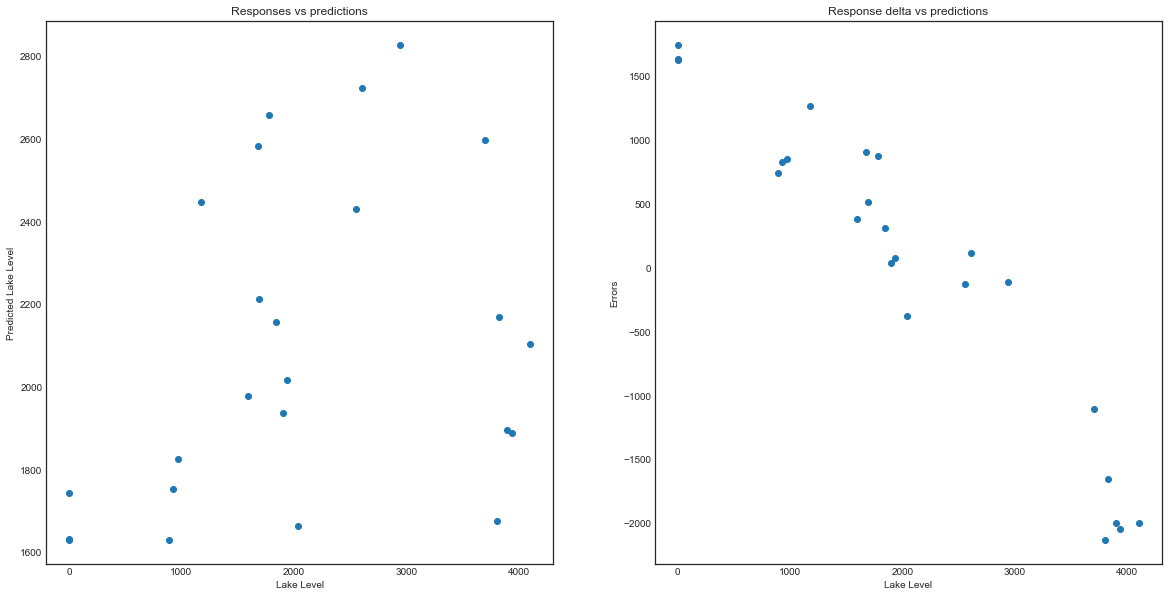

In [155]:
plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.scatter(y_test, y_pred)
plt.title("Responses vs predictions")
plt.xlabel("Lake Level")
plt.ylabel("Predicted Lake Level")
ax = plt.gca()
# ax.set_xlim([0, 25000])
# ax.set_ylim([0, 25000])

plt.subplot(122)
plt.scatter(y_test, y_preddelta)
plt.title("Response delta vs predictions")
plt.xlabel("Lake Level")
plt.ylabel("Errors")
ax = plt.gca()
# ax.set_xlim([0, 35000])
# ax.set_ylim([-25000, 10000])


print mean_absolute_error(y_test, y_pred)

# Plotting Code

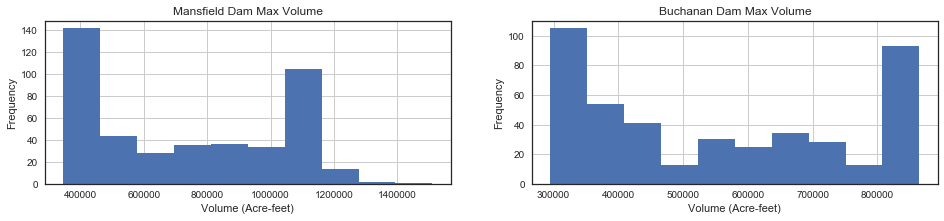

In [228]:
plt.figure(figsize=(16, 3))

plt.subplot(121)
ydf['Mansfield Dam_max'].hist()
plt.style.use('seaborn-white')
plt.ylabel('Frequency')
plt.xlabel("Volume (Acre-feet)")
plt.title("Mansfield Dam Max Volume")

plt.subplot(122)
ydf['Buchanan Dam_max'].hist()
plt.style.use('seaborn-white')
plt.ylabel('Frequency')
plt.xlabel("Volume (Acre-feet)")
plt.title("Buchanan Dam Max Volume")
plt.savefig('images/eda_max_hist.png')



# INFLOW


In [64]:
ydf.describe()

,Mansfield Dam_max,Buchanan Dam_max,Mansfield Dam_min,Buchanan Dam_min,Mansfield Dam Inflow,Buchanan Dam Inflow,Storm Duration
count,4.360000e+02,436.000000,4.360000e+02,436.000000,436.000000,436.000000,436
mean,7.434443e+05,552828.231651,7.330637e+05,548466.353211,10380.651376,4361.878440,3 days 03:01:03.165137
std,3.009422e+05,196729.957243,2.957030e+05,195685.712010,27632.706426,8003.256438,3 days 16:17:10.293399
min,3.461400e+05,295049.000000,3.384180e+05,293891.000000,0.000000,0.000000,0 days 00:10:00
25%,4.342230e+05,356173.000000,4.301335e+05,353609.000000,1823.500000,1235.750000,1 days 11:35:00
50%,7.030510e+05,540462.000000,6.945990e+05,536301.000000,3826.000000,2166.000000,1 days 20:31:30
75%,1.070084e+06,729185.000000,1.060454e+06,716418.250000,8289.250000,4338.250000,3 days 02:46:00
max,1.510106e+06,864604.000000,1.255796e+06,844934.000000,386628.000000,89334.000000,31 days 16:15:00


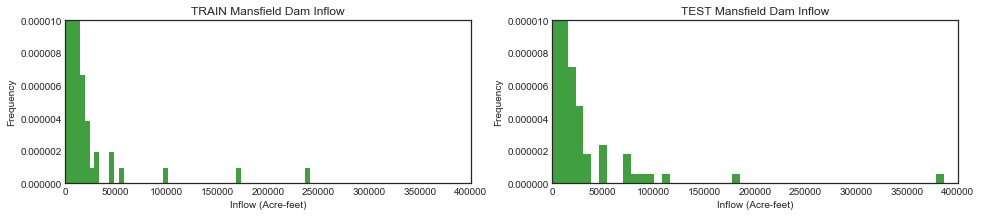

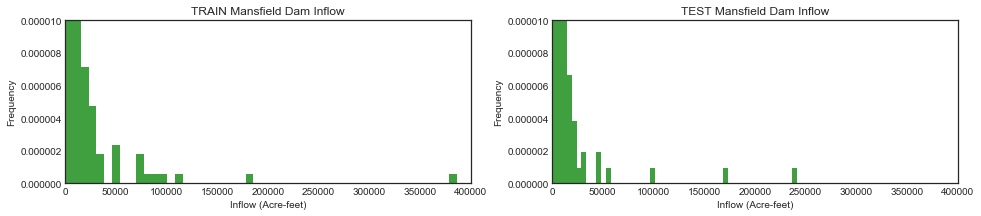

In [61]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold

kf = KFold(n_splits=2)

X = Xdf.iloc[:, 2:].values
y = ydf.loc[:, "Mansfield Dam Inflow"].values



for train_index, test_index in kf.split(X):
    
    plt.figure(figsize=(16, 3))
    plt.subplot(121)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    plt.hist(y_train, 50, normed=1, facecolor='green', alpha=0.75)
    plt.style.use('seaborn-white')
    plt.ylabel('Frequency')
    plt.xlabel("Inflow (Acre-feet)")
    plt.title("TRAIN Mansfield Dam Inflow")
    ax = plt.gca()
    ax.set_xlim([0, 400000])
    ax.set_ylim([0, 0.00001])

    plt.subplot(122)
    plt.hist(y_test, 50, normed=1, facecolor='green', alpha=0.75)
    plt.style.use('seaborn-white')
    plt.ylabel('Frequency')
    plt.xlabel("Inflow (Acre-feet)")
    plt.title("TEST Mansfield Dam Inflow")
    ax = plt.gca()
    ax.set_xlim([0, 400000])
    ax.set_ylim([0, 0.00001])
    # plt.savefig('images/eda_inflowgreater_hist.png')
    plt.show()





# ax = ydf[ydf['Mansfield Dam Inflow'] > 40000]['Mansfield Dam Inflow'].hist()
# plt.style.use('seaborn-white')
# plt.ylabel('Frequency')
# plt.xlabel("Inflow (Acre-feet)")
# plt.title("Mansfield Dam Inflow Greater than 50000")

# plt.subplot(122)
# ax = ydf[ydf['Buchanan Dam Inflow'] > 40000]['Buchanan Dam Inflow'].hist()
# plt.style.use('seaborn-white')
# plt.ylabel('Frequency')
# plt.xlabel("Inflow (Acre-feet)")
# plt.title("Buchanan Dam Inflow Greater than 50000")
# plt.savefig('images/eda_inflowgreater_hist.png')


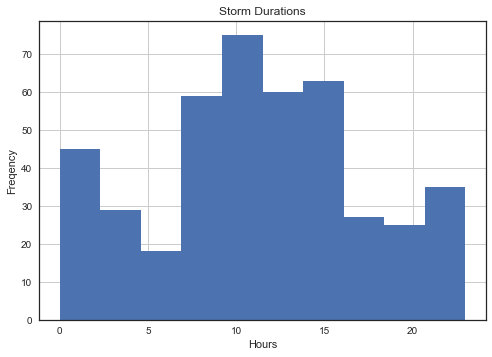

In [281]:
ydf['Storm Duration'].apply(lambda x: x.seconds / 3600).hist()
plt.title("Storm Durations")
plt.ylabel("Freqency")
plt.xlabel("Hours")
plt.savefig('images/stormduration.png')

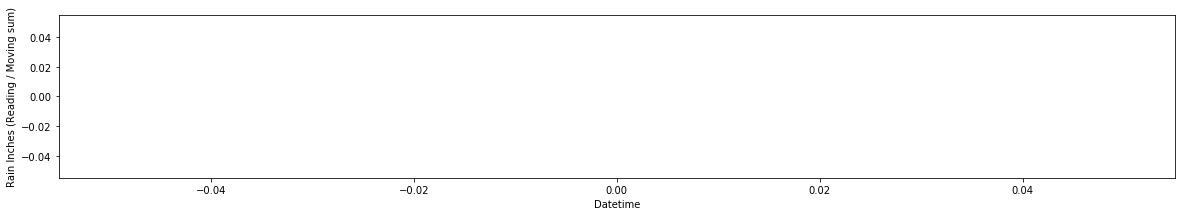

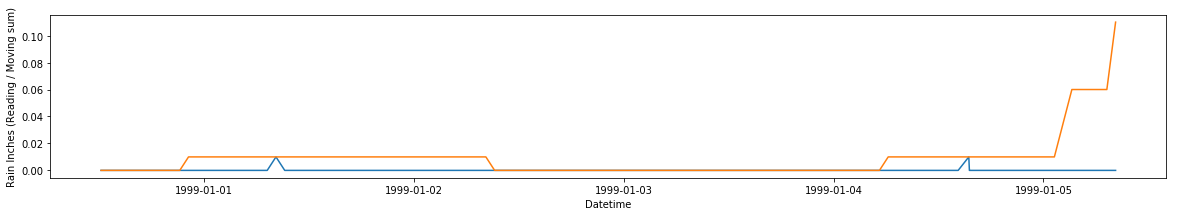

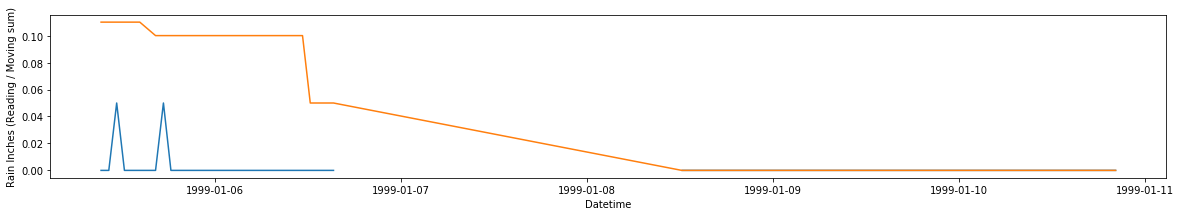

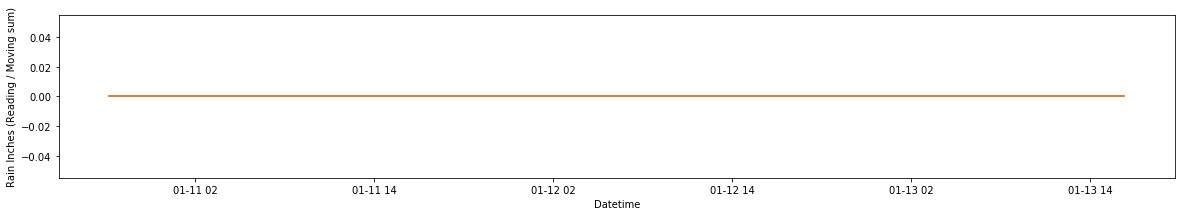

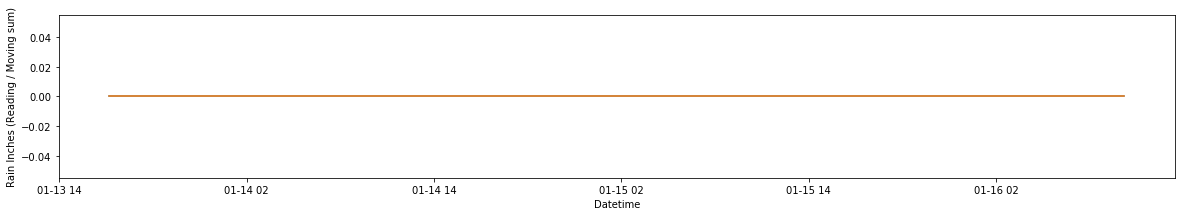

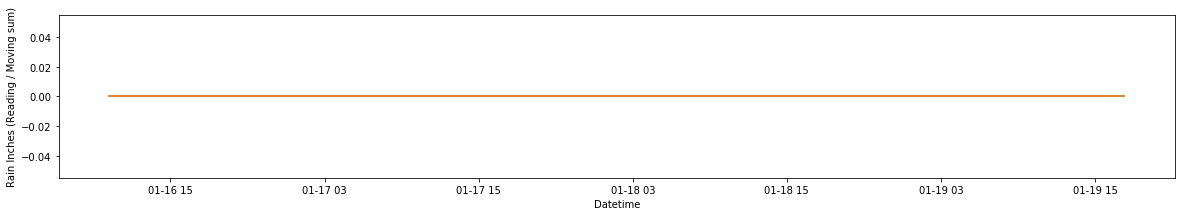

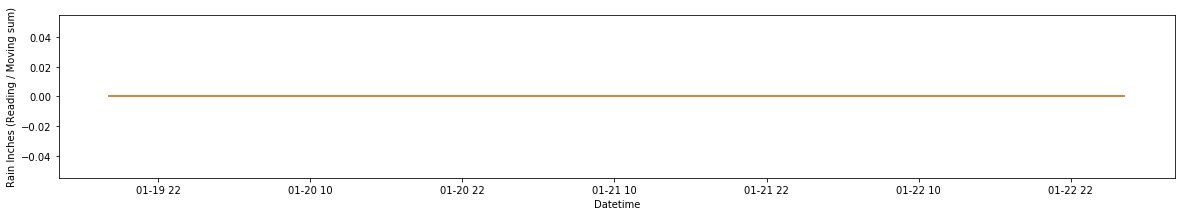

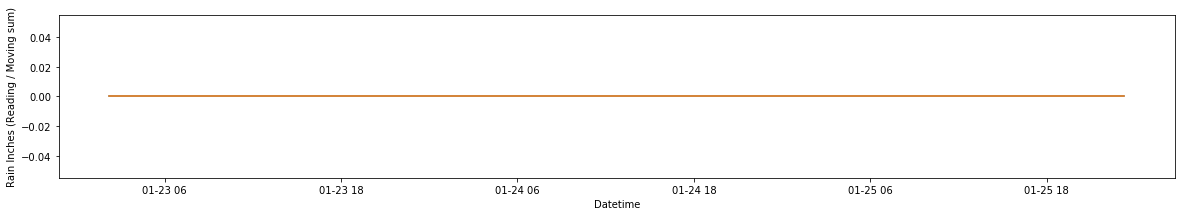

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline



interval = df.shape[0] / 8
nextstart = 0
for i in xrange(0, df.shape[0], interval):
    
    plt.figure(figsize=(20, 3))
    plt.subplot(111)
    plt.plot(msdf[nextstart:i].index.values, msdf['Rain (inches)'][nextstart:i].values)
    plt.plot(msdf[nextstart:i].index.values, msdf['moving_rain_sum'][nextstart:i].values)
    plt.ylabel("Rain Inches (Reading / Moving sum)")
    plt.xlabel("Datetime")
    plt.show()
    nextstart = i